In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import wfdb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import neurokit2 as nk
from scipy.signal import resample, medfilt
import pywt
import pickle
import time
import os
import mne
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
def preprocessing_data(signal, target_rate=100, original_rate=360):
    coeffs = pywt.wavedec(signal, 'db4', level=5) #Wavelet decomposition, reduces noise, enhances key elements
    signal = pywt.waverec(coeffs, 'db4')
    signal = medfilt(signal, kernel_size=5) #Reduces noise further

    signal = downsample(signal, original_rate=original_rate, target_rate=target_rate) #Downsample form 360Hz to 100Hz, then feed sequences of 500Hz
    return np.array(signal)

In [3]:
def load_record(record_id, seq_len=1000, stride=1000):
    record_name = str(record_id)
    if not os.path.exists(f"mit_bih/{record_name}.dat"):
        wfdb.dl_database('mitdb', './', records=[record_name])
    record = wfdb.rdrecord('mit_bih/' + record_name)
    
    #Extract each channel
    signal_data = record.p_signal
    ch1 = preprocessing_data(signal_data[:, 0]).reshape(-1, 1)
    ch2 = preprocessing_data(signal_data[:, 1]).reshape(-1, 1)
    
    #Scale the signal
    scaler = MinMaxScaler(feature_range=(0, 1))
    ch1_scale = scaler.fit_transform(ch1)
    ch2_scale = scaler.fit_transform(ch2)
    
    # Create sequences using sliding window
    seq_ch1 = [ch1_scale[i:i+seq_len] for i in range(0, len(ch1_scale)-seq_len+1, stride)]
    seq_ch2 = [ch2_scale[i:i+seq_len] for i in range(0, len(ch2_scale)-seq_len+1, stride)]
    seq_ch1.extend(seq_ch2)
    return seq_ch1

def load_multiple_records(record_ranges, seq_len=1000, stride_len=100):
    all_data = []
    for start, end in gmai
    tqdm(record_ranges):
        for record_id in range(start, end + 1):
            record_data = load_record(record_id, seq_len, stride_len)
            all_data.extend(record_data)
    # Save to pkl
    with open('database.pkl', 'wb') as f:
        pickle.dump(all_data, f)
    
    return all_data

In [4]:
def downsample(data, original_rate, target_rate):
    num_samples = int(len(data) * target_rate / original_rate)
    return resample(data, num_samples)

def calculate_l1(predictions, targets):
    l1_norm = torch.norm(predictions-targets, p=1)
    l1_sum = torch.sum(torch.abs(targets))
    accuracy = 100 * (1 - (l1_norm / l1_sum))
    return accuracy

def calculate_l2(predictions, targets):
    l2_norm = torch.norm(predictions - targets, p=2)
    l2_sum = torch.norm(targets, p=2)
    accuracy = 100 * (1 - (l2_norm / l2_sum))
    return accuracy

def calculate_MAPE(predictions, targets):
    mape = torch.mean(torch.abs((targets - predictions) / targets))
    return mape

In [6]:
def fixed_position_mask_peaks(rpeaks, seq, mask_length, num_peaks_to_mask):
    mask = np.zeros_like(seq, dtype=bool)  # Create a mask with the same length as seq, initially all False

    if len(rpeaks) > 0:  # If there are detected peaks
        # Randomly select 'num_peaks_to_mask' peaks from rpeaks
        selected_peaks = rpeaks[1:2*num_peaks_to_mask + 1: 2]

        for peak in selected_peaks:
            mask_half = mask_length // 2
            start = int(max(0, peak - mask_half))
            end = int(min(len(seq), peak + mask_half))
            mask[start:end] = True
    
    return mask

In [7]:
class ECGDataset(Dataset):
    def __init__(self, data, seq_len=1000, mask_length=60, target_rate=100,num_peaks_to_mask=1):
        """
        Args:
            data (np.array): Full ECG signal data.
            seq_len (int): Length of each sequence before downsampling.
            mask_length (int): Length of masking window around the first R-peak.
            original_rate (int): Original sampling rate of the data (default: 360 Hz).
            target_rate (int): Target sampling rate after downsampling (default: 100 Hz).
        """
        self.data = data
        self.seq_len = seq_len
        self.mask_length = mask_length
        self.target_rate = target_rate
        self.num_peaks_to_mask = num_peaks_to_mask
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Adjust index for downsampled sequences
        seq = self.data[idx].flatten()
        # Detect R-peaks in the sequence
        rpeaks = nk.ecg_findpeaks(seq, sampling_rate=self.target_rate)['ECG_R_Peaks']

        # Create masking array
        mask = np.zeros_like(seq, dtype=bool)
        mask = fixed_position_mask_peaks(rpeaks, seq, self.mask_length, self.num_peaks_to_mask)

        masked_seq = seq.copy()
        masked_seq[mask] = 0  # Apply masking

        mask = torch.tensor(mask, dtype=torch.bool)
        return torch.tensor(masked_seq, dtype=torch.float32), torch.tensor(seq, dtype=torch.float32), mask

In [8]:
# Masked Autoencoder
class MAE1D(nn.Module):
    def __init__(self, seq_len, embed_dim=32, hidden_dim=64, lstm_hidden_dim=128):
        super(MAE1D, self).__init__()
        self.seq_len = seq_len
        self.encoder = nn.Sequential(
            nn.Conv1d(1, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(embed_dim, embed_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(embed_dim * 2, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # BiLSTM layer, processes sequence forwards and backwars
        self.bilstm = nn.LSTM(hidden_dim, lstm_hidden_dim, bidirectional=True, batch_first=True)

        self.decoder = nn.Sequential(
            nn.Conv1d(lstm_hidden_dim * 2, embed_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),

            nn.Conv1d(embed_dim * 2, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True),

            nn.Conv1d(embed_dim, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, mask):
        # print(f"Input shape: {x.shape}")
        x = x.unsqueeze(1)
        # print(f"Shape after unsqueeze (adding channel): {x.shape}")
        encoded = self.encoder(x)
        # print(f"Shape after encoding: {encoded.shape}")
        encoded = encoded.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(encoded)
        
        lstm_out = lstm_out.permute(0, 2, 1)
        decoded = self.decoder(lstm_out)

        x_reconstructed = decoded.squeeze(1)
        # print(f"Shape after squeeze: {x_reconstructed.shape}")

        return x_reconstructed

In [10]:
# Data preparation
def prepare_data(data, seq_len, num_rpeaks,batch_size=128):
    dataset = ECGDataset(data, seq_len, num_peaks_to_mask = num_rpeaks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [11]:
def evaluate_model(model, val_loader, device='cuda'):
    criterion = nn.MSELoss()
    model.eval()
    val_loss = 0.0
    l1_accuracy = 0.0
    l2_accuracy = 0.0
    MAPE_accuracy = 0.0

    model.eval()
    with torch.no_grad():
        for masked_seq, original_seq, mask in tqdm(val_loader, desc="Evaluating", leave=False):
            masked_seq, original_seq, mask = masked_seq.to(device), original_seq.to(device), mask.to(device)
            reconstructed = model(masked_seq, mask)
            masked_reconstructed = reconstructed[mask]
            masked_original = original_seq[mask]
            loss = criterion(masked_reconstructed, masked_original)
            val_loss += loss.item()
            l1_accuracy += calculate_l1(masked_reconstructed, masked_original)
            l2_accuracy += calculate_l2(masked_reconstructed, masked_original)
            MAPE_accuracy += calculate_MAPE(masked_reconstructed, masked_original)

    avg_l1 = l1_accuracy / len(val_loader)
    avg_l2 = l2_accuracy / len(val_loader)
    avg_MAPE = MAPE_accuracy / len(val_loader)

    print(f"\nValidation Loss: {val_loss / len(val_loader):.4f}")
    print(f"L1 Accuracy: {avg_l1:.4f}")
    print(f"L2 Accuracy: {avg_l2:.4f}")
    print(f"MAPE Accuracy: {avg_MAPE:.2f}%")

In [12]:
# Training
def train_model_with_plot(model, train_loader, val_loader, epochs, patience=10, max_hours=5, lr=0.001, file_save = 'best_model.pth',device='mps'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    # last best validation loss variable, set to 0.
    best_val_loss = float('inf')
    # loss patience counter
    patience_counter = 0

    start_time = time.time()
    max_time = max_hours * 3600

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for masked_seq, original_seq, mask in train_loader:
            masked_seq, original_seq, mask = masked_seq.to(device), original_seq.to(device), mask.to(device)

            optimizer.zero_grad()
            reconstructed = model(masked_seq, mask)

            loss_global = criterion(reconstructed, original_seq)
            loss_masked = criterion(reconstructed[mask], original_seq[mask])
            loss = 0.9 * loss_masked + 0.1 * loss_global

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        val_loss = 0.0
        l1_accuracy = 0
        l2_accuracy = 0
        MAPE_accuracy = 0
        model.eval()
        with torch.no_grad():
            for masked_seq, original_seq, mask in val_loader:
                masked_seq, original_seq, mask = masked_seq.to(device), original_seq.to(device), mask.to(device)
                reconstructed = model(masked_seq, mask)
                masked_reconstructed = reconstructed[mask]
                masked_original = original_seq[mask]
                loss = criterion(masked_reconstructed, masked_original)
                val_loss += loss.item()
                l1_accuracy += calculate_l1(masked_reconstructed, masked_original)
                l2_accuracy += calculate_l2(masked_reconstructed, masked_original)
                MAPE_accuracy += calculate_MAPE(masked_reconstructed, masked_original)

        val_losses.append(val_loss / len(val_loader))
        avg_l1 = l1_accuracy / len(val_loader)
        avg_l2 = l2_accuracy / len(val_loader)
        avg_MAPE = MAPE_accuracy / len(val_loader)

        print(f"Epoch {epoch}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, , L1 Accuracy: {avg_l1:.2f}, L2 Accuracy: {avg_l2:.2f}, MAPE Accuracy: {avg_MAPE:.2f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), file_save)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    evaluate_model(model, val_loader)
    # Visualize predictions vs. actual data
    plot_predictions_with_residuals(model, val_loader, device)
    plot_loss_curves(train_losses, val_losses)


In [13]:
def plot_some_sample(data_loader, device, num_samples=5):
    all_actual, all_masks = [], []
    with torch.no_grad():
        for masked_seq, original_seq, mask in data_loader:
            all_actual.extend(original_seq)  # original (unmasked) ECG
            all_masks.extend(mask) # Masked regions
            break
            
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(min(num_samples, len(all_actual))):
        original = all_actual[i]
        mask = all_masks[i]

        # Plot predictions vs actual data
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.plot(original, label="Original", color="blue", alpha=0.7)

        # Highlight masked regions
        masked_indices = np.where(mask)[0]
        plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)

        plt.title(f"Sample {i + 1} - Predictions")
        plt.legend()    
        
def plot_predictions_with_residuals(model, data_loader, device, num_samples=2):
    model.eval()
    all_actual, all_predicted, all_masks = [], [], []
    
    with torch.no_grad():
        for masked_seq, original_seq, mask in data_loader:
            masked_seq, original_seq = masked_seq.to(device), original_seq.to(device)
            reconstructed = model(masked_seq, mask)
            all_actual.extend(original_seq.cpu().numpy())  # original (unmasked) ECG
            all_predicted.extend(reconstructed.cpu().numpy())  # predictions
            all_masks.extend(mask.cpu().numpy()) # Masked regions
            break  # Take only one batch for plotting
    
    # Flatten the lists for metric calculation
    all_actual_flat = np.concatenate(all_actual)
    all_predicted_flat = np.concatenate(all_predicted)
    
    # Calculate metrics
    mse = mean_squared_error(all_actual_flat, all_predicted_flat)
    mae = mean_absolute_error(all_actual_flat, all_predicted_flat)
    r2 = r2_score(all_actual_flat, all_predicted_flat)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Visualize predictions vs. actual data with residuals
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(min(num_samples, len(all_actual))):
        original = all_actual[i]
        predicted = all_predicted[i]
        mask = all_masks[i]

        # Plot predictions vs actual data
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.plot(original, label="Original", color="blue", alpha=0.7)
        plt.plot(predicted, label="Predicted", color="orange", alpha=0.7)

        # Highlight masked regions
        masked_indices = np.where(mask)[0]
        plt.scatter(masked_indices, original[masked_indices], color="red", label="Masked Regions", alpha=0.7)

        plt.title(f"Sample {i + 1} - Predictions")
        plt.legend()

        # Compute and plot residuals
        residuals = np.array(original) - np.array(predicted)
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.plot(residuals, label="Residuals", color="green")
        plt.axhline(0, color="black", linestyle="--")
        plt.title(f"Sample {i + 1} - Residuals")
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()

Working with data


100%|███████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.64it/s]


(168576, 5000, 1)
Training the model with 8 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0063, Val Loss: 0.0025, , L1 Accuracy: 94.03, L2 Accuracy: 90.09, MAPE Accuracy: inf
Epoch 1, Train Loss: 0.0019, Val Loss: 0.0016, , L1 Accuracy: 95.19, L2 Accuracy: 92.06, MAPE Accuracy: inf
Epoch 2, Train Loss: 0.0014, Val Loss: 0.0013, , L1 Accuracy: 95.71, L2 Accuracy: 92.94, MAPE Accuracy: inf
Epoch 3, Train Loss: 0.0012, Val Loss: 0.0011, , L1 Accuracy: 96.13, L2 Accuracy: 93.54, MAPE Accuracy: inf
Epoch 4, Train Loss: 0.0010, Val Loss: 0.0010, , L1 Accuracy: 96.30, L2 Accuracy: 93.87, MAPE Accuracy: inf
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0009, , L1 Accuracy: 96.48, L2 Accuracy: 94.13, MAPE Accuracy: inf
Epoch 6, Train Loss: 0.0008, Val Loss: 0.0008, , L1 Accuracy: 96.75, L2 Accuracy: 94.42, MAPE Accuracy: inf
Epoch 7, Train Loss: 0.0007, Val Loss: 0.0007, , L1 Accuracy: 96.85, L2 Accuracy: 94.60, MAPE Accuracy: inf
Epoch 8, Train Loss: 0.0007, Val Loss: 0.0007,


Validation Loss: 0.0003
L1 Accuracy: 97.9335
L2 Accuracy: 96.4273
MAPE Accuracy: inf%
Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0057
R-squared (R²): 0.9920


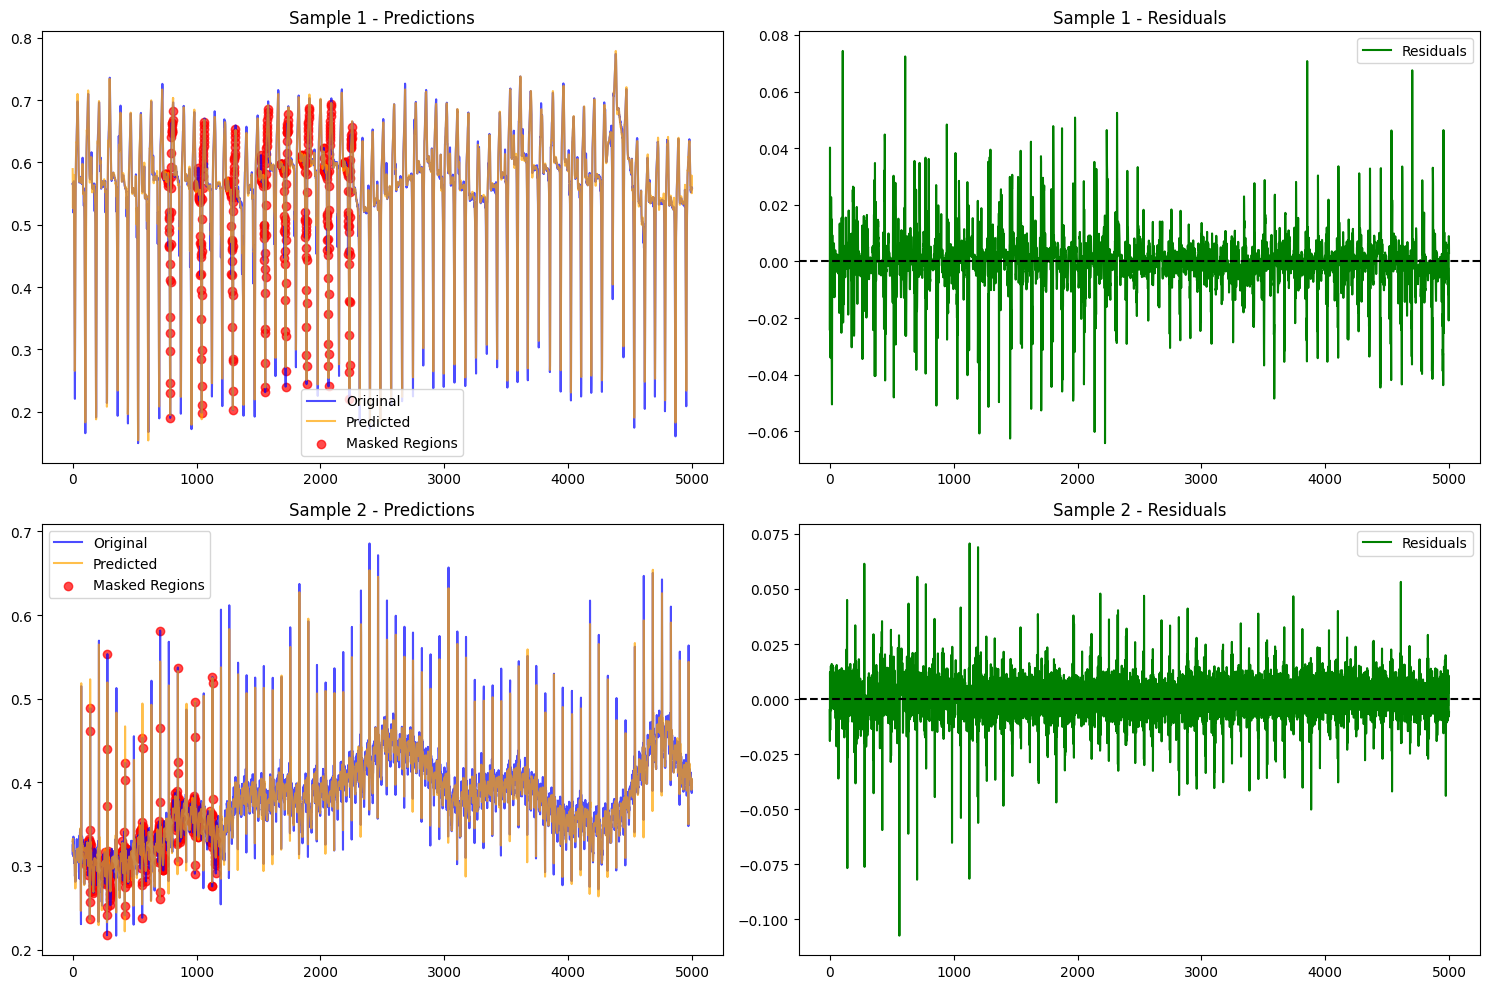

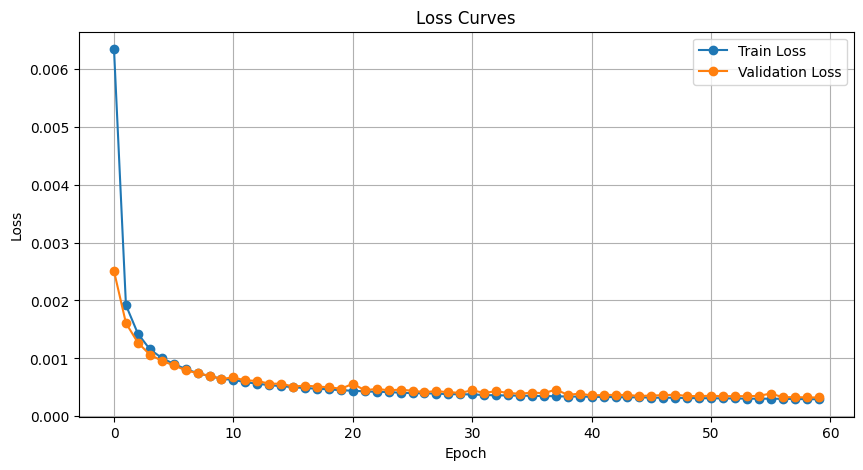

In [17]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,234)]
print("Working with data")
seq_len = 5000
data = np.array(load_multiple_records(record_ranges, 5000, 100))
print(data.shape)
for num in [8]:
    print("="*20)
    print(f"Training the model with {num} R peaks")
    print("="*20)
    
    print("Preparing the data")
    train_loader, val_loader = prepare_data(data,num_rpeaks = num, seq_len=seq_len)
    
    print("Training the model")
    mae_model = MAE1D(seq_len=seq_len)
    train_model_with_plot(mae_model, train_loader, val_loader, epochs=60, device='cuda', file_save = f'best_model_{num}_1_rpeaks.pth')

Working with data


100%|███████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


(16896, 5000, 1)
Training the model with 8 R peaks
Preparing the data
Training the model
Epoch 0, Train Loss: 0.0349, Val Loss: 0.0071, , L1 Accuracy: 88.44, L2 Accuracy: 83.27, MAPE Accuracy: inf
Epoch 1, Train Loss: 0.0063, Val Loss: 0.0057, , L1 Accuracy: 90.61, L2 Accuracy: 85.08, MAPE Accuracy: inf
Epoch 2, Train Loss: 0.0056, Val Loss: 0.0054, , L1 Accuracy: 91.13, L2 Accuracy: 85.45, MAPE Accuracy: inf
Epoch 3, Train Loss: 0.0054, Val Loss: 0.0053, , L1 Accuracy: 91.31, L2 Accuracy: 85.59, MAPE Accuracy: inf
Epoch 4, Train Loss: 0.0052, Val Loss: 0.0049, , L1 Accuracy: 91.88, L2 Accuracy: 86.11, MAPE Accuracy: inf
Epoch 5, Train Loss: 0.0048, Val Loss: 0.0045, , L1 Accuracy: 91.92, L2 Accuracy: 86.74, MAPE Accuracy: inf
Epoch 6, Train Loss: 0.0042, Val Loss: 0.0047, , L1 Accuracy: 91.54, L2 Accuracy: 86.45, MAPE Accuracy: inf
Epoch 7, Train Loss: 0.0039, Val Loss: 0.0039, , L1 Accuracy: 92.72, L2 Accuracy: 87.68, MAPE Accuracy: inf
Epoch 8, Train Loss: 0.0036, Val Loss: 0.0035, 


Validation Loss: 0.0009
L1 Accuracy: 96.3771
L2 Accuracy: 93.9107
MAPE Accuracy: inf%
Mean Squared Error (MSE): 0.0006
Mean Absolute Error (MAE): 0.0127
R-squared (R²): 0.9590


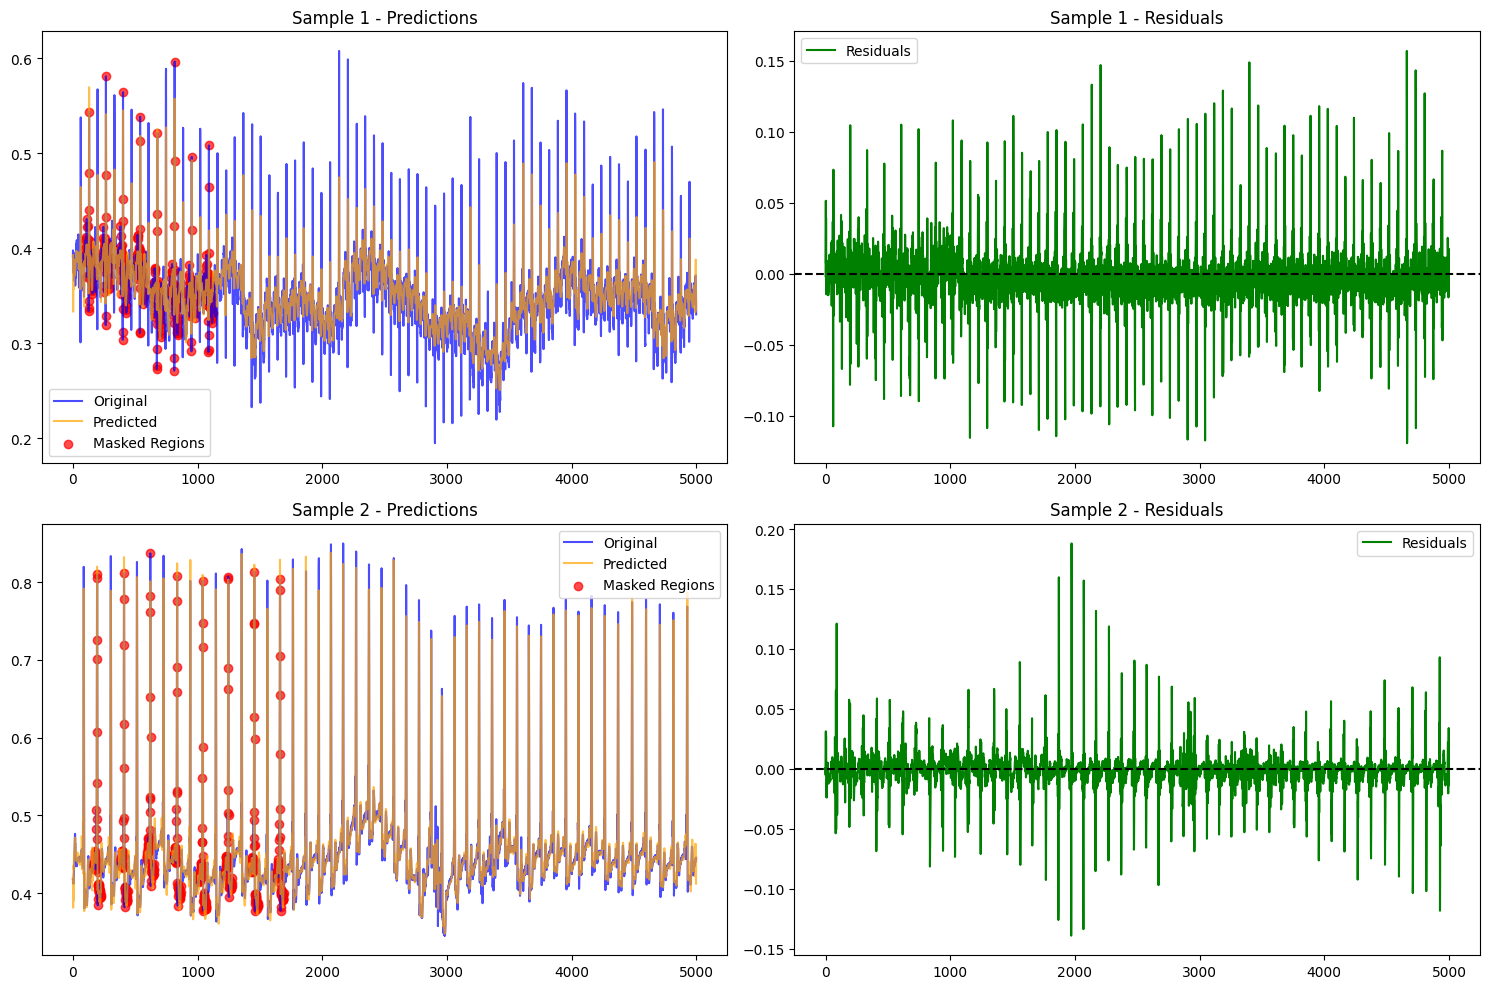

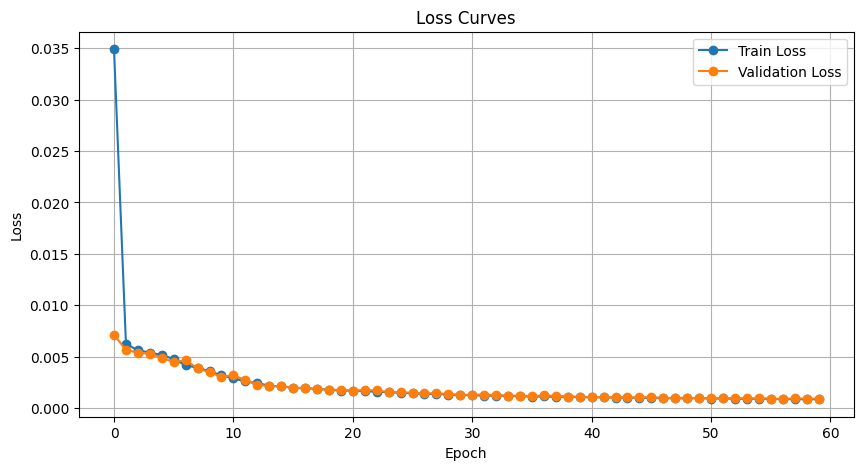

In [16]:
record_ranges = [(100,109),(111, 119),(121,124),(200,203),(205,205),(207,210),(212,215),(217,217),(219,223),(228,228),(230,234)]
print("Working with data")
seq_len = 5000
data = np.array(load_multiple_records(record_ranges, 5000, 1000))
print(data.shape)
for num in [8]:
    print("="*20)
    print(f"Training the model with {num} R peaks")
    print("="*20)
    
    print("Preparing the data")
    train_loader, val_loader = prepare_data(data,num_rpeaks = num, seq_len=seq_len)
    
    print("Training the model")
    mae_model = MAE1D(seq_len=seq_len)
    train_model_with_plot(mae_model, train_loader, val_loader, epochs=60, device='cuda', file_save = f'best_model_{num}_1_rpeaks.pth')

In [21]:
test_data = load_multiple_records([(233,234)])
test_dataset = ECGDataset(test_data, seq_len, num_peaks_to_mask = 2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
evaluate_model(mae_model, val_loader, device='cuda')

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]
                                                                                                                     


Validation Loss: 0.0024
L1 Accuracy: 95.9639
L2 Accuracy: 91.5880
MAPE Accuracy: 0.04%


In [21]:
from torch.utils.data import DataLoader, TensorDataset

def load_wesad_dataset(root_dir, test_subject):
    folder_ls = os.listdir(root_dir)
    for i in folder_ls:
        if i == ".ipynb_checkpoints" or i == '.DS_Store':
            print(f"Removing {i}")
            folder_ls.remove(i)
    
    valid_ls = ['S2']
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]

    # Create the train list by excluding test_ls
    train_ls = [subject for subject in folder_ls if subject not in valid_ls]
    print("==========Loading Training set============")
    X_train, y_train = load_process_extract_ls(root_dir, train_ls,700, 5,5,True)
    print("==========Loading Testing set============")
    X_test, y_test = load_process_extract_ls(root_dir,valid_ls,700, 5, 5,False)
    return X_train, X_test, y_train, y_test
    
class ECGClassificationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: [N, L]
        self.Y = Y  # shape: [N]
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = self.X[idx].flatten()
        return torch.tensor(seq, dtype=torch.float32).unsqueeze(0), torch.tensor(self.Y[idx], dtype=torch.long)

In [22]:
from data_processing_qrs_80f1 import *
X_train, X_test, y_train, y_test = load_wesad_dataset('/home/van/NamQuang/ECG_Research/WESAD_LOSO', 'S2.pkl')
train_dataloader = ECGClassificationDataset(X_train, y_train)
test_dataloader = ECGClassificationDataset(X_test, y_test)

Removing .DS_Store
==========Loading Training set============
5-15
remove nonstress: 1
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S16/S16.pkl
5-15
remove nonstress: 17
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S9/S9.pkl
5-15
remove nonstress: 26
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S13/S13.pkl
5-15
remove nonstress: 2
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S8/S8.pkl
5-15
remove nonstress: 5
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S4/S4.pkl
5-15
remove nonstress: 0
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S11/S11.pkl
5-15
remove nonstress: 23
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S15/S15.pkl
5-15
remove nonstress: 2
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S3/S3.pkl
5-15
remove nonstress: 2
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S6/S6.pkl
5-15
remove nonstress: 5
Working with: /home/van/NamQuang/ECG_Research/WESAD_LOSO/S7/S7.pkl
5-15
re

In [23]:
train_size = int(0.8 * len(train_dataloader))
val_size = len(train_dataloader) - train_size
train_dataset, val_dataset = random_split(train_dataloader, [train_size, val_size])

train_loader_wesad = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_wesad = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_wesad = DataLoader(test_dataloader, batch_size=128, shuffle=False)

In [24]:
import torch.nn.functional as F


class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim = 64, num_classes=2):
        super(DownstreamClassifier, self).__init__()
        self.encoder = encoder
        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Classifier head after GAP
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),  # hidden_dim = last conv channels output
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)  # shape: (B, C=hidden_dim, L)
        
        # Global Average Pooling over the sequence dimension (L)
        z = F.adaptive_avg_pool1d(z, 1)  # shape: (B, C, 1)
        z = z.squeeze(-1)                 # shape: (B, C)
        logits = self.classifier(z)
        return logits

In [25]:
# Load model and pretrained weights
auto_model = MAE1D(seq_len = 1000)
auto_model.load_state_dict(torch.load('best_model_8_5_rpeaks.pth', weights_only=True))
frozen_encoder = auto_model.encoder
model = DownstreamClassifier(frozen_encoder)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Train loop
model.train()
num_epochs = 200

val_losses = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []

    for x, y in train_loader_wesad:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(y.cpu().numpy())

    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in val_loader_wesad:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}: "
          f"Train Loss = {total_loss/len(train_loader):.4f}, "
          f"Train Acc = {train_accuracy:.4f}, "
          f"Train F1 = {train_f1_macro:.4f} | "
          f"Val Loss = {avg_val_loss:.4f}, "
          f"Val Acc = {val_accuracy:.4f}, "
          f"Val F1 = {val_f1_macro:.4f}")

Epoch 0: Train Loss = 0.0299, Train Acc = 0.7637, Train F1 = 0.4494 | Val Loss = 0.0272, Val Acc = 0.7750, Val F1 = 0.4392
Epoch 1: Train Loss = 0.0255, Train Acc = 0.7857, Train F1 = 0.4836 | Val Loss = 0.0237, Val Acc = 0.7895, Val F1 = 0.5030
Epoch 2: Train Loss = 0.0229, Train Acc = 0.8093, Train F1 = 0.6113 | Val Loss = 0.0215, Val Acc = 0.8252, Val F1 = 0.6435
Epoch 3: Train Loss = 0.0215, Train Acc = 0.8200, Train F1 = 0.6663 | Val Loss = 0.0201, Val Acc = 0.8367, Val F1 = 0.6840
Epoch 4: Train Loss = 0.0204, Train Acc = 0.8253, Train F1 = 0.6899 | Val Loss = 0.0193, Val Acc = 0.8482, Val F1 = 0.7474
Epoch 5: Train Loss = 0.0188, Train Acc = 0.8424, Train F1 = 0.7180 | Val Loss = 0.0183, Val Acc = 0.8391, Val F1 = 0.6866
Epoch 6: Train Loss = 0.0181, Train Acc = 0.8474, Train F1 = 0.7314 | Val Loss = 0.0179, Val Acc = 0.8651, Val F1 = 0.7951
Epoch 7: Train Loss = 0.0172, Train Acc = 0.8586, Train F1 = 0.7542 | Val Loss = 0.0166, Val Acc = 0.8621, Val F1 = 0.7492
Epoch 8: Train L

In [27]:
from sklearn.metrics import f1_score
import torch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
def evaluate_f1_macro(model, dataloader, criterion, device):
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_val, y_val in dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro')
    val_losses.append(avg_val_loss)
    
    return avg_val_loss, val_f1_macro

val_loss, val_f1 = evaluate_f1_macro(model, test_loader_wesad, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Macro F1 Score: {val_f1:.4f}")

Validation Loss: 0.0196, Macro F1 Score: 0.3286
